## Plot box and whisker plots showing bias spread at sites
Last updated: Kevin Varga, 12/31/2024

**Inputs:**
* Netcdf of modeled LFM values
* CSV of observed and bias corrected LFM at all sites
* CSV of locations of LFM observations

**Outputs:**
* Box/whisker of original and bias corrected bias at LFM obs sites
* CDFs of observed, predicted, corrected
* Scatter and regression between observed, corrected

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
obs_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_model/stats/'
output_path = '/home/sbarc/students/varga/nasa/ch1/figures/bias_correction/'

In [14]:
# Read in LFM observations, predictions and bias corrections at observation sites
predict_df = pd.read_csv(obs_path + 'all_fuels_obs_predictions.csv', index_col=['fuel','site','date'],
                         parse_dates=True, infer_datetime_format=True)
# Subset for chamise
fuel_type = 'chamise'
fuel_df = predict_df.loc[fuel_type]

# Extract site names
sites = pd.unique(fuel_df.index.get_level_values('site').unique())

In [15]:
# Calculate the bias at every time step for both bias corrected and non-bias corrected modeled chamise LFM
fuel_df['corrected_bias'] = fuel_df.loc[:, 'predicted'] - fuel_df.loc[:, 'observed']
fuel_df['original_bias'] = fuel_df.loc[:, 'no_bias_correction'] - fuel_df.loc[:, 'observed']

# Create dataframe to store mean bias error at every site
site_bias = pd.DataFrame(index=sites, columns=['og_mbe','cor_mbe'])

# Loop through sites and calculate original and bias corrected MBE
for site_name in sites:
    site_bias.loc[site_name,'og_mbe'] = fuel_df.loc[site_name]['original_bias'].mean()
    site_bias.loc[site_name,'cor_mbe'] = fuel_df.loc[site_name]['corrected_bias'].mean()

In [5]:
# Calculate and print original and corrected global MBE
print('Original MBE: ', round(fuel_df['original_bias'].mean(), 4))
print('Corrected MBE: ', round(fuel_df['corrected_bias'].mean(), 4))
# Calculate and print original and corrected bias standard deviation
print('Original bias std: ', round(fuel_df['original_bias'].std(), 4))
print('Corrected bias std: ', round(fuel_df['corrected_bias'].std(), 4))

Original MBE:  -1.4266
Corrected MBE:  -0.3649
Original bias std:  15.0491
Corrected bias std:  14.43


In [6]:
# Determine the 14 sites with the largest original bias
site_bias['og_mbe'] = pd.to_numeric(site_bias['og_mbe'], errors='coerce')
site_bias['abs_og_mbe'] = abs(site_bias['og_mbe'])
top_bias_sites = site_bias.nlargest(14, 'abs_og_mbe').index.to_list()

In [7]:
# Subset the dataframe to the sites with largest original bias
df = fuel_df.loc[(top_bias_sites), ['original_bias','corrected_bias']].dropna()
df.reset_index(inplace=True)

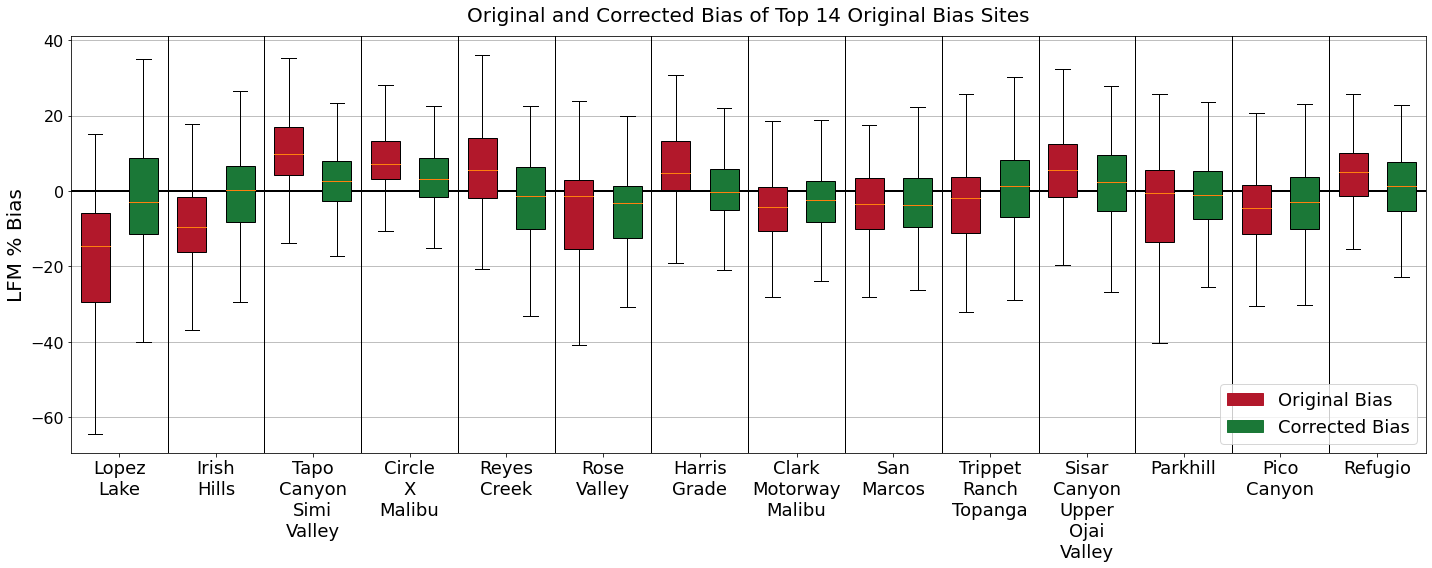

In [8]:
# Create list of site names for plotting
site_names = [site_name.replace('_','\n').title() for site_name in top_bias_sites]

# Create the boxplot
fig = plt.figure(figsize=(20, 8))
sites = df['site'].unique()
num_sites = len(sites)
positions = range(1, num_sites * 2, 2)
original_bias_data = np.array([df[df['site'] == site]['original_bias'].values for site in sites], dtype=object)
corrected_bias_data = np.array([df[df['site'] == site]['corrected_bias'].values for site in sites], dtype=object)

# Define flier properties
flierprops = dict(marker='o', markersize=3, markerfacecolor='red', linestyle='none')

plt.boxplot(original_bias_data, positions=positions, widths=0.6, showfliers=False,
            patch_artist=True, meanline=True, flierprops=flierprops, boxprops={'facecolor':'#b2182b'})
# Boxplot for corrected_bias_data with different box color
bp = plt.boxplot(corrected_bias_data, positions=[pos + 1 for pos in positions], widths=0.6, showfliers=False,
                 patch_artist=True, meanline=True, flierprops=flierprops, boxprops={'facecolor':'#1b7837'})

# Add vertical lines between box plots
for i in range(1, len(df['site'].unique()) * 2, 2):
    plt.axvline(x=i + 1.5, color='black', linestyle='-', linewidth=1)

# Customize the plot
#plt.xticks(range(1, num_sites * 2 + 1, 2), site_names) #, ha='right')
plt.xticks([pos + 0.5 for pos in positions], site_names) #, ha='right')

#plt.legend(['Original Bias', 'Corrected Bias'], loc='best')
plt.title('Original and Corrected Bias of Top 14 Original Bias Sites', fontsize=20, pad=15)
plt.ylabel('LFM % Bias', fontsize=20)
plt.tick_params(axis='y', labelsize=16) #, labelweight='bold')
plt.tick_params(axis='x', labelsize=18)
plt.grid(axis='y')

# Create legend handles and labels
original_patch = mpatches.Patch(color='#b2182b', label='Original Bias')
corrected_patch = mpatches.Patch(color='#1b7837', label='Corrected Bias')
plt.legend(handles=[original_patch, corrected_patch], loc='best', fontsize=18)

# Set the linewidth of the y-axis line at 0
plt.axhline(0, color='black', linewidth=2)

plt.tight_layout()
plt.show()

fig.savefig(output_path + 'top14site_bias_correction_boxes.png', dpi = 600, bbox_inches='tight');

### Plot cumulative distribution functions

In [9]:
import statsmodels.api as sm

In [16]:
# Extract fuel and variables
fuel_type = 'chamise'
fuel_df = predict_df.loc[fuel_type]
observed = fuel_df.loc[:, 'observed'].dropna()
predicted = fuel_df.loc[observed.index, 'no_bias_correction']
corrected = fuel_df.loc[observed.index, 'predicted']

In [17]:
# Calculate the CDFs
cdf_original = sm.distributions.ECDF(observed)
cdf_predicted = sm.distributions.ECDF(predicted)
cdf_corrected = sm.distributions.ECDF(corrected)

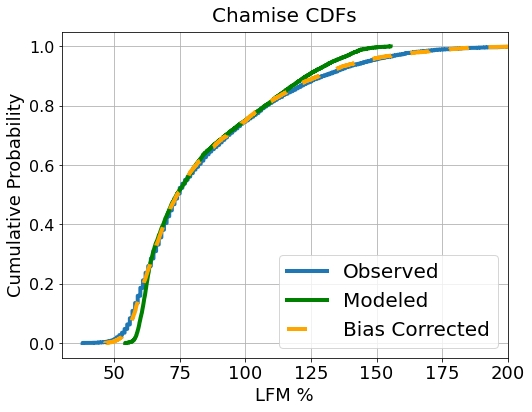

In [18]:
# Create the plot
fig = plt.figure(figsize=(8, 6))
plt.step(cdf_original.x, cdf_original.y, label='Observed', where='post', linewidth=4)
plt.step(cdf_predicted.x, cdf_predicted.y, label='Modeled', where='post', linewidth=4, color='green')
plt.step(cdf_corrected.x, cdf_corrected.y, label='Bias Corrected', where='post', linestyle=(0,(5,5)), linewidth=4, color='orange')

# Add labels and title
plt.xlim(30,200)
plt.xlabel('LFM %', fontsize=18)
plt.ylabel('Cumulative Probability', fontsize=18)
plt.tick_params(axis='y', labelsize=16) #, labelweight='bold')
plt.tick_params(axis='x', labelsize=18)
plt.title('Chamise CDFs', fontsize=20, pad=10)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()

fig.savefig(output_path + 'CDFs.png', dpi = 500, bbox_inches='tight');

### Plot corrected vs observed

In [19]:
from scipy.stats import linregress

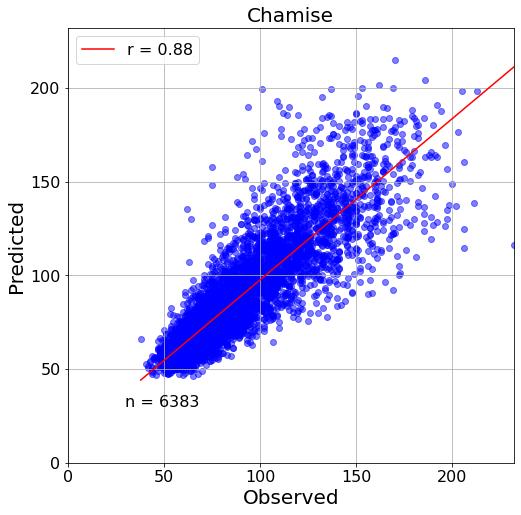

In [20]:
# Subset fuel
fuel_type = 'chamise'
fuel_df = predict_df.loc[fuel_type]
title = 'Chamise'

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(fuel_df['observed'],fuel_df['predicted'])

# Find largest value between observed and predicted
if fuel_df['observed'].max() >= fuel_df['predicted'].max(): max_value = fuel_df['observed'].max()
if fuel_df['predicted'].max() > fuel_df['observed'].max(): max_value = fuel_df['predicted'].max()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(fuel_df['observed'], fuel_df['predicted'], color='blue', alpha=0.5)
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.ylabel('Predicted', fontsize=20)
plt.xlabel('Observed', fontsize=20)
plt.tick_params(axis='both', labelsize=16) #, labelweight='bold')
plt.title(title, fontsize=20)

# Create x values that span just the range of your observed data
x_range = np.linspace(fuel_df['observed'].min(), fuel_df['observed'].max(), 100)
# Plot the regression line using these x values
plt.plot(x_range, slope * x_range + intercept,
         color='red', label=f'r = {r_value:.2f}')

plt.annotate(f'n = {len(fuel_df)}', xy=(30,30), fontsize=16)

plt.legend(fontsize=16, loc='upper left')
plt.grid(True)
plt.show()

fig.savefig(output_path + fuel_type + '_scatter.png', dpi = 500, bbox_inches='tight');